In [1]:
%matplotlib widget
from bmcs_shell.api import FETriangularMesh, TriXDomainFE, XDomainFE, FETS2D3U1M, MATS2DElastic, TriXDomainMITC, FETS2DMITC, MATSShellElastic
import numpy as np
from ibvpy.bcond import BCDof
from ibvpy.sim.tstep_bc import TStepBC
# from ibvpy.mats.viz3d_scalar_field import \
#     Vis3DStateField, Viz3DScalarField

In [2]:
def run_sim(mitc = True):
    mesh = FETriangularMesh(
    X_Id=[[0,0,0], [0,100,0], [100,0,0]],
    I_Fi=[[0,1,2]] # this should be I_Ei when using XDomainFE later
    )
    if mitc:
        # shell element with 5 dofs (u_x, u_y, u_z, alpha, beta)
        fixed_dofs = [0, 1, 2, 3, 4,
                      5   , 7, 8, 9,
                            12, 13, 14]
        loaded_dofs = [11]
        mesh.fets = FETS2DMITC()
        xdomain = TriXDomainMITC(mesh=mesh)
        tmodel = MATSShellElastic(E=210000, nu=0.3)
    else:
        # plane element
        fixed_dofs = [0, 1, 2, 3, 5, 8]
        loaded_dofs = [7]
        xdomain = TriXDomainFE(mesh=mesh)
        tmodel = MATS2DElastic(E=210000, nu=0.3)

    u_cntl = -100
    bc_fixed = [BCDof(var= 'u', dof=dof, value=0) for dof in fixed_dofs]
    bc_loaded = [BCDof(var= 'f', dof=dof, value=u_cntl) for dof in loaded_dofs]
    ts = TStepBC(
        domains=[(xdomain, tmodel)],
        bc=bc_fixed + bc_loaded,
    )
    s = ts.sim
    s.tloop.k_max = 10
    s.tline.step = 1
    s.tloop.verbose = True
#     s.run()
    return xdomain

In [3]:
xdomain = run_sim(mitc = True)

**X position Vectors** 

In [4]:
X_Fid = xdomain.X_Id[xdomain.mesh.I_Fi]
X_Fid

array([[[  0.,   0.,   0.],
        [  0., 100.,   0.],
        [100.,   0.,   0.]]])

**V_n Vectors** 

In [5]:
a = 1 # thickness

n_Fd= xdomain.norm_F_normals
el_nodes_num = 3
Vn_Fid = np.tile(n_Fd, (1, 1, el_nodes_num)).reshape(n_Fd.shape[0], n_Fd.shape[1], el_nodes_num)
Vn_Fid = 0.5 * a * Vn_Fid
Vn_Fid

array([[[0. , 0. , 0.5],
        [0. , 0. , 0.5],
        [0. , 0. , 0.5]]])

In [6]:
fets = xdomain.fets
dN_imr = fets.dN_imr
dNt_imr = fets.dNt_imr

In [7]:
dN_imr = xdomain.fets.dN_imr
dNt_imr = xdomain.fets.dNt_imr

X_Fid = xdomain.X_Id[xdomain.mesh.I_Fi]

a = 1  # thickness
n_Fd = xdomain.norm_F_normals
el_nodes_num = 3
Vn_Fid = np.tile(n_Fd, (1, 1, el_nodes_num)).reshape(n_Fd.shape[0], n_Fd.shape[1], el_nodes_num)

dx_dr1_Fmrid = np.einsum('Fid, imr ->Fmrid', X_Fid, dN_imr)
dx_dr2_Fmrid = np.einsum('Fid, imr ->Fmrid', 0.5 * a * Vn_Fid, dNt_imr)
dx_dr1_Fmrd = np.sum(dx_dr1_Fmrid, axis=3)
dx_dr2_Fmrd = np.sum(dx_dr2_Fmrid, axis=3)
dx_dr_Fmrd = dx_dr1_Fmrd + dx_dr2_Fmrd

# Calculating v1 and v2
min_Fi1 = Vn_Fid.argmin(axis=2)
min_Fi1 = min_Fi1[..., np.newaxis]
tmp_Fid = np.zeros_like(Vn_Fid, dtype=np.int_)
tmp_Fid[..., :] = np.arange(3)
min_mask_Fid = tmp_Fid == min_Fi1
e_x_min_Fid = min_mask_Fid * 1
V1_Fid = np.cross(e_x_min_Fid, Vn_Fid)
V2_Fid = np.cross(Vn_Fid, V1_Fid)
v1_Fid = xdomain._normalize(V1_Fid)
v2_Fid = xdomain._normalize(V2_Fid)

# Calculating du_dr
U_o = np.arange(3 * 5) # TODO change
nodes_num = xdomain.mesh.X_Id.shape[0]
U_Ie = np.reshape(U_o, (nodes_num, xdomain.fets.n_nodal_dofs))
U_Fie = U_Ie[xdomain.mesh.I_Fi]
disp_U_Fia = U_Fie[..., :3]
rot_U_Fib = U_Fie[..., 3:]
du_dr1_Fmria = np.einsum('Fia, imr ->Fmria', disp_U_Fia, dN_imr)
du_dr1_Fmra = np.sum(du_dr1_Fmria, axis=3)

alpha_idx = 0
beta_idx = 1
alpha_Fi1 = rot_U_Fib[..., alpha_idx, np.newaxis]
beta_Fi1 = rot_U_Fib[..., beta_idx, np.newaxis]
v2_alpha_Fid = v2_Fid * alpha_Fi1
v1_beta_Fid = v1_Fid * beta_Fi1
v1_v2_dif_Fid = v1_beta_Fid - v2_alpha_Fid
du_dr2_Fmria = np.einsum('Fia, imr ->Fmria', 0.5 * a * v1_v2_dif_Fid, dNt_imr)
du_dr2_Fmra = np.sum(du_dr2_Fmria, axis=3)
du_dr_Fmra = du_dr1_Fmra + du_dr2_Fmra

In [8]:
dN_imr[:, 0, 0] # dh1/dr, dh2/dr, dh3/dr for GP 1

array([-1.,  1.,  0.])

In [9]:
dNt_imr[:, 0, 0] # d(t*h1)/dr, d(t*h2)/dr, d(t*h3)/dr, for GP 1

array([ 0.57735026, -0.57735026,  0.        ])

In [10]:
# dh1/dr*I | -0.5 * a * v2_Fid * dNt_imr | 0.5 * a * v1_Fid * dNt_imr

In [11]:
element_dofs = 3 * fets.n_nodal_dofs
dN_dr_Emrco = np.zeros((*dx_dr_Fmrd.shape, element_dofs))

In [12]:
# Filling first 3x3 elements from N matrices
dofs = 5
# Looping r, s, t
for i in range(3):
    # Looping h1, h2, h3
    for j in range(3):
        dN_dr_Emrco[..., i, :, 0 + j*dofs:3 + j*dofs] = np.identity(3) * dN_imr[j, 0, i] # dh1/dr (which is the same for all gaus points)

In [13]:
dN_dr_Emrco[0, 0, 0, ...]

array([[-1., -0., -0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [-0., -1., -0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [-0., -0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]])

In [14]:
N4_Fmrai = np.einsum('Fia, imr ->Fmrai', -0.5 * a * v2_Fid, dNt_imr)
N5_Fmrai = np.einsum('Fia, imr ->Fmrai', +0.5 * a * v1_Fid, dNt_imr)

In [15]:
N4_Fmrai.shape

(1, 14, 3, 3, 3)

In [16]:
dN_dr_Emrco[..., :, [3, 8, 13]].shape

(1, 14, 3, 3, 3)

In [17]:
N4_Fmrai[0, 0, 1, ...]

array([[-0.28867513,  0.        ,  0.28867513],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [18]:
dN_dr_Emrco[..., :, [3, 8, 13]] = N4_Fmrai
dN_dr_Emrco[..., :, [4, 9, 14]] = N5_Fmrai

\begin{align}
 u_a = N_{ao} u_{o}
\end{align}
\begin{align}
\varepsilon_{ab} &= \frac{1}{2}
\left(\frac{\partial u_a}{\partial x_b} +
 \frac{\partial u_b}{\partial x_a}\right) \\
&= \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \frac{\partial u_c}{\partial x_d}
\\
&=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \frac{\partial N_{co}}{\partial x_d} u_o
\\
 &=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
\frac{\partial N_{co}}{\partial \xi_r} \frac{\partial \xi_r}{\partial x_d} u_o
\end{align}

$u_{o}$: the calculated nodal displacements

$\frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
\frac{\partial N_{co}}{\partial \xi_r} \frac{\partial \xi_r}{\partial x_d}$: represents the $B$ operator

In [26]:
x_Ia = xdomain.X_Id
x_Eia = x_Ia[xdomain.I_Ei]
delta = np.identity(3)
Diff1_abcd = 0.5 * (
    np.einsum('ac,bd->abcd', delta, delta) +
    np.einsum('ad,bc->abcd', delta, delta)
)

J_Fmrd = dx_dr_Fmrd

inv_J_Fmrd = np.linalg.inv(J_Fmrd)
det_J_Fmrd = np.linalg.det(J_Fmrd)
B_Emabo = np.einsum('abcd, Emrco, Emrd -> Emabo', Diff1_abcd, dN_dr_Emrco, inv_J_Fmrd)

U_o = np.array([0, 0, 0, 0, 0,
               0, 0, 0, 0, 0,
               0, 1, 0, 0, 0], dtype=np.float_)
eps_Emab = np.einsum('Emabo, o -> Emab', B_Emabo, U_o)
eps_Emab

array([[[[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.005, 0.   ],
         [0.005, 0.   , 0.   ],
         [0.   , 0.   , 0.   ]],

        [[0.   , 0.0

In [93]:
# Replace diagonal elements with a number
ddd = np.identity(3) * np.arange(3)
ddd[[0, 1, 2], [0, 1, 2]] = 15
ddd
# example: dN_dr_Emrco[..., [0, 1, 2], [0, 1, 2]] = dh/dr

array([0., 1., 2.])

In [35]:
x = np.array([1, 2, 3])
np.broadcast_to(x, (2, 3, 3))

array([[[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]])

## Benchmark example

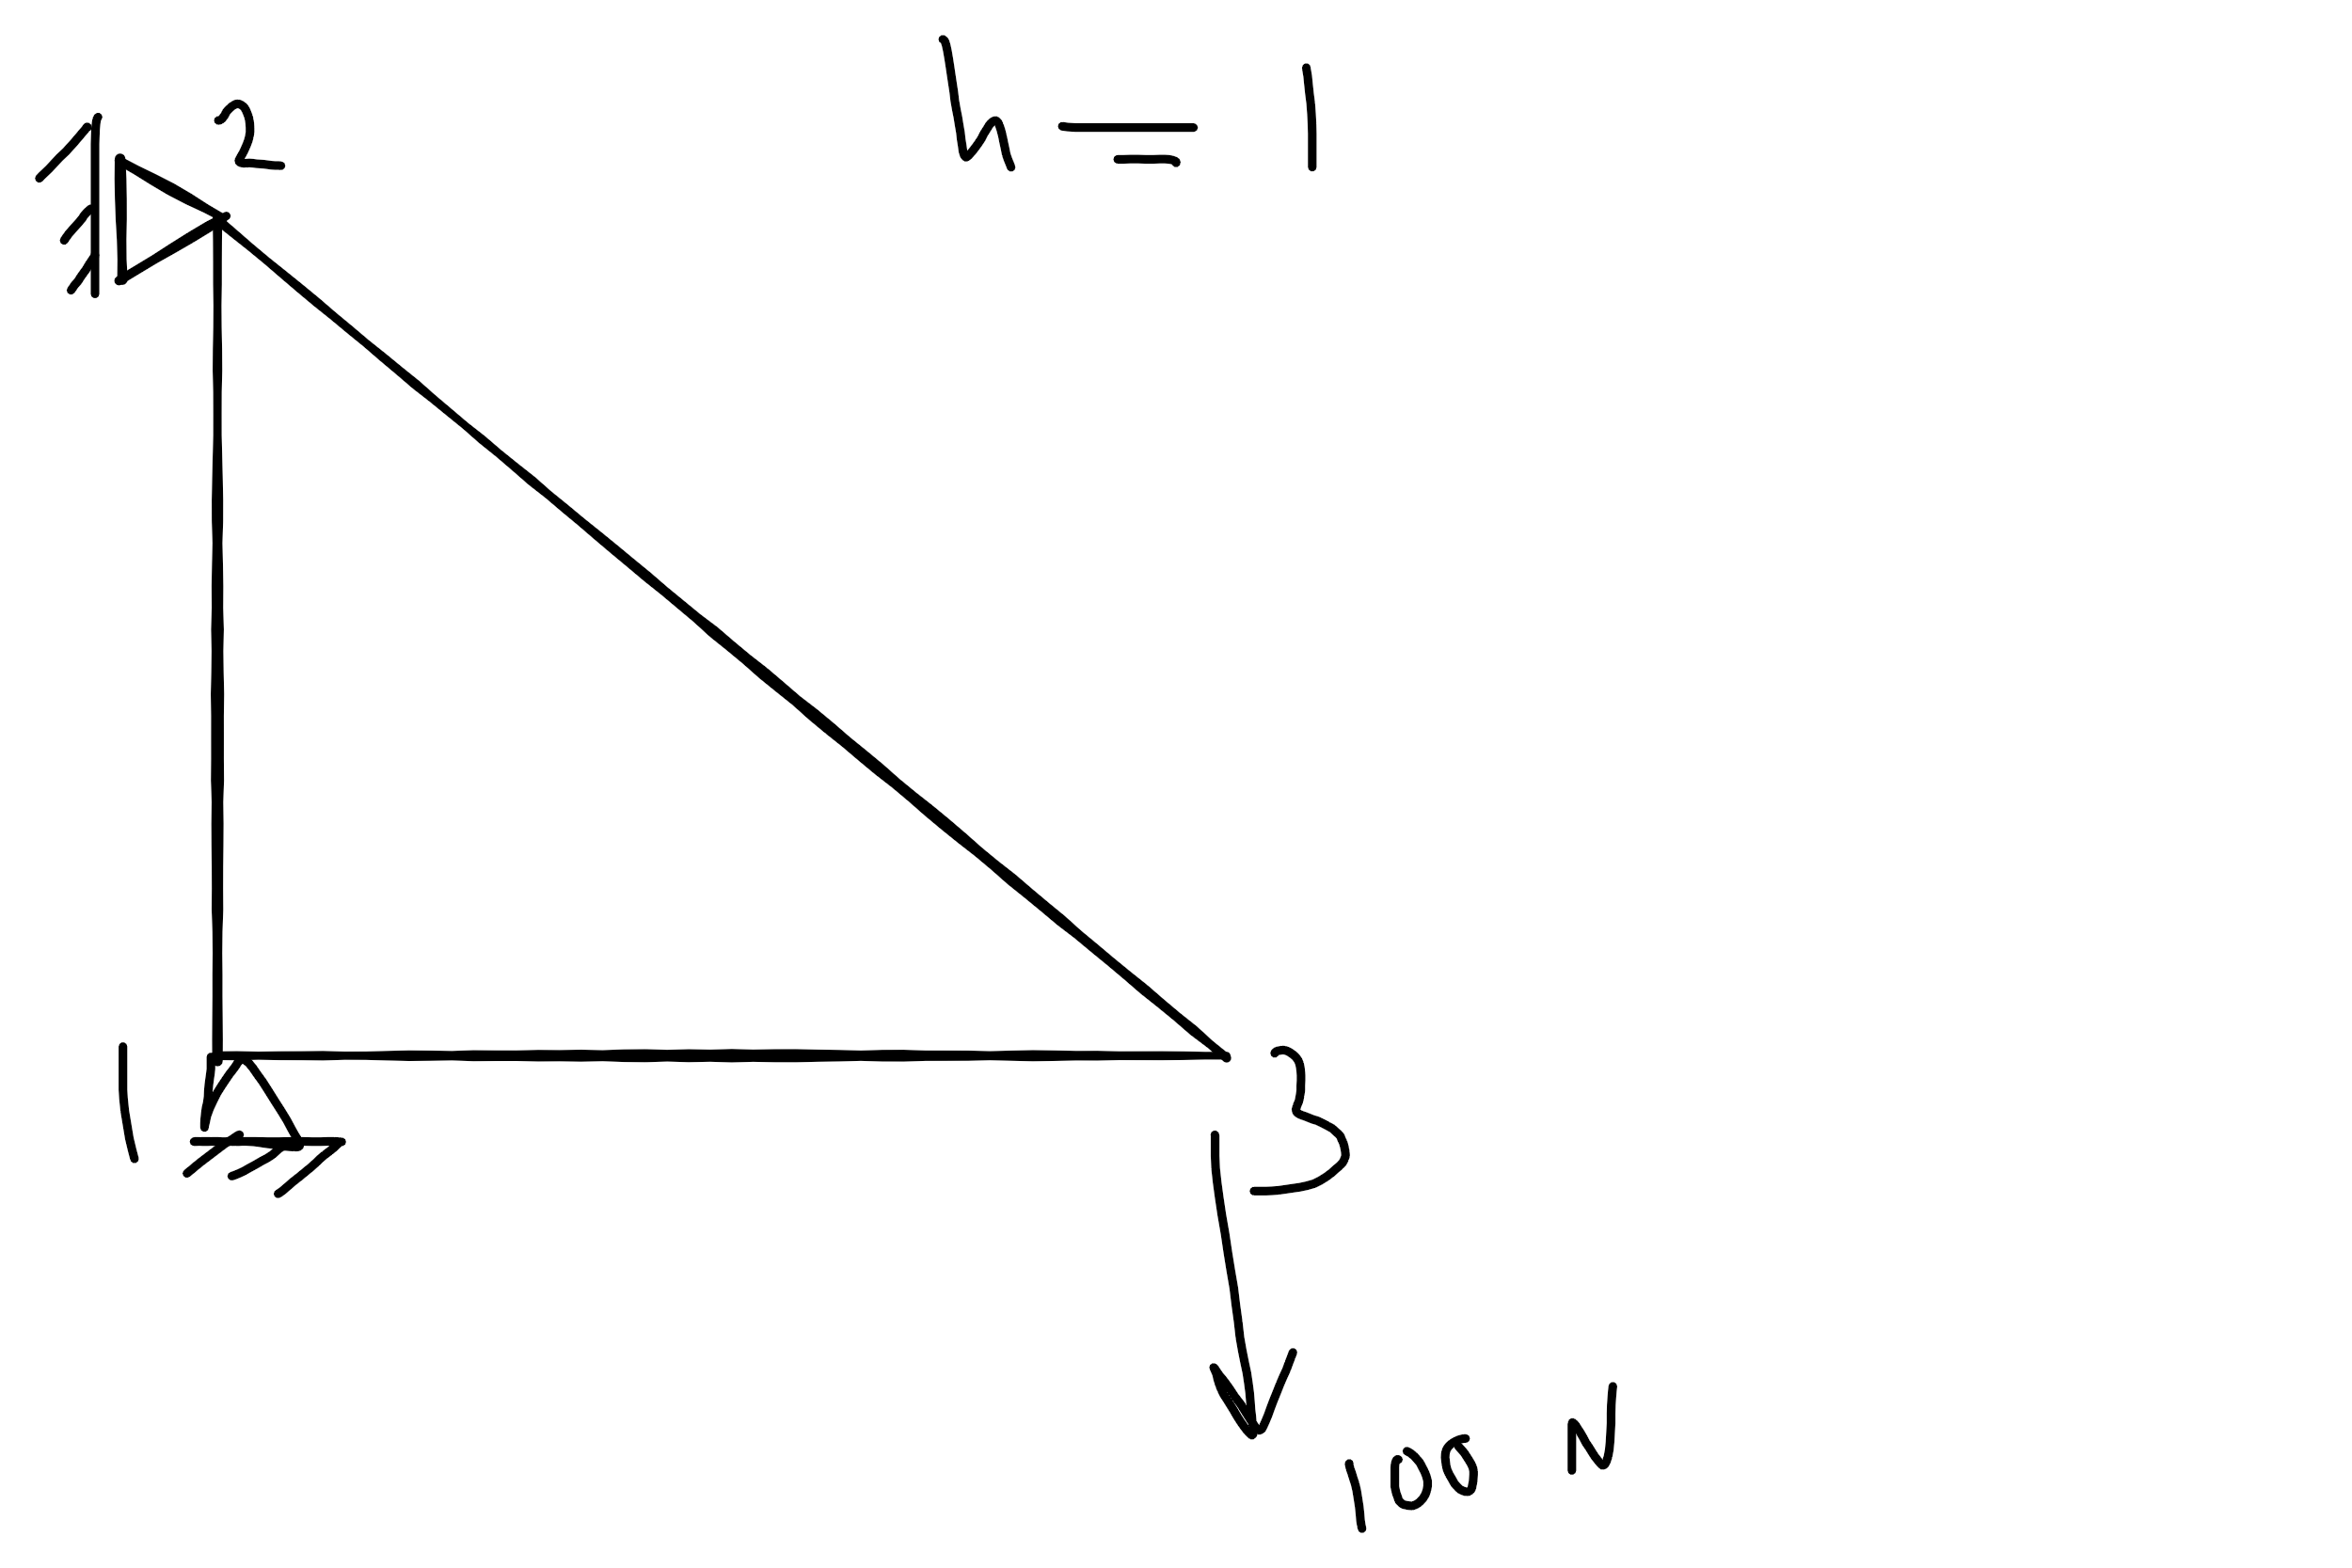

## 1. Solving manually

In [2]:
h = 1

x1 = 0
y1 = 0
x2 = 0
y2 = 100
x3 = 100
y3 = 0

E = 210000
nu = 0.3
A = 100*100/2
C = E / (1 - nu ** 2) * np.array([[1, nu, 0], [nu, 1, 0], [0, 0, 0.5 * (1 - nu)]])
B = (1/(2*A)) * np.array([
    [y2-y3, 0, y3-y1, 0, y1-y2, 0],
    [0, x3-x2, 0, x1-x3, 0, x2-x1],
    [x3-x2, y2-y3, x1-x3, y3-y1, x2-x1, y1-y2]
])
B

array([[ 0.01,  0.  ,  0.  ,  0.  , -0.01,  0.  ],
       [ 0.  ,  0.01,  0.  , -0.01,  0.  ,  0.  ],
       [ 0.01,  0.01, -0.01,  0.  ,  0.  , -0.01]])

In [3]:
k = A*h*np.dot(B.T, C)
k = np.dot(k, B)
k

array([[ 155769.23076923,   75000.        ,  -40384.61538462,
         -34615.38461538, -115384.61538462,  -40384.61538462],
       [  75000.        ,  155769.23076923,  -40384.61538462,
        -115384.61538462,  -34615.38461538,  -40384.61538462],
       [ -40384.61538462,  -40384.61538462,   40384.61538462,
              0.        ,       0.        ,   40384.61538462],
       [ -34615.38461538, -115384.61538462,       0.        ,
         115384.61538462,   34615.38461538,       0.        ],
       [-115384.61538462,  -34615.38461538,       0.        ,
          34615.38461538,  115384.61538462,       0.        ],
       [ -40384.61538462,  -40384.61538462,   40384.61538462,
              0.        ,       0.        ,   40384.61538462]])

In [4]:
k_dof = k[3:,3:]
k_dof

array([[115384.61538462,  34615.38461538,      0.        ],
       [ 34615.38461538, 115384.61538462,      0.        ],
       [     0.        ,      0.        ,  40384.61538462]])

In [5]:
k_inv = np.linalg.inv(k_dof)
k_inv

array([[ 9.52380952e-06, -2.85714286e-06,  0.00000000e+00],
       [-2.85714286e-06,  9.52380952e-06,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.47619048e-05]])

In [6]:
f = np.array([0, 0, -100])
u = np.dot(k_inv, f)
u

array([ 0.        ,  0.        , -0.00247619])

## 2. Solving using ibvpy

In [8]:
xdomain.T_Fab

array([[[-0.70710678,  0.70710678,  0.        ],
        [-0.70710678, -0.70710678, -0.        ],
        [ 0.        ,  0.        ,  1.        ]]])

In [9]:
xdomain.x_Eia

array([[[  0.        ,   0.        ],
        [141.42135624,   0.        ],
        [ 70.71067812,  70.71067812]]])

In [10]:
xdomain.J_Emar

array([[[[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.

In [ ]:
F_to = ts.hist.F_t
U_to = ts.hist.U_t
F_loaded = np.sum(F_to[:, loaded_dofs], axis=-1)
F_fixed = np.sum(F_to[:, fixed_dofs], axis=-1)
U_loaded = np.average(U_to[:, loaded_dofs], axis=-1)
F_loaded
U_to[-1]

In [ ]:
U1 = ts.hist.U_t[-1]
print(U1)
eps1 = ts.fe_domain[0].xdomain.map_U_to_field(U1)
sig1, _ = ts.fe_domain[0].tmodel.get_corr_pred(eps1,1)
sig_x, sig_y, tau = sig1.T
sig_ab = np.einsum('ab...->...ab', np.array([[sig_x, tau], [tau, sig_y]], dtype=np.float))
sig_val, sig_dir = np.linalg.eig(sig_ab)
[np.min(sig_val), np.max(sig_val)]

In [ ]:
Diff1_abcd

$$
J_{ar} =  \frac{\partial N_i}{\partial \eta_r} 
x_{ia}
$$
this can be transformed 
$$
J_{Emar} = \left. \frac{\partial N_i}{\partial \eta_r} \right|_m
x_{Eia}
$$
Zienkiewicz

In [18]:
x_Ia = xdomain.X_Id[..., :-1]
x_Eia = x_Ia[xdomain.I_Ei]
delta = np.identity(2) 
Diff1_abcd = 0.5 * (
        np.einsum('ac,bd->abcd', delta, delta) +
        np.einsum('ad,bc->abcd', delta, delta)
)
dN_mir = np.array([[[1, 0], [0, 1], [-1, -1]]], dtype=np.float_)
J_Emar = np.einsum('mir, Eia -> Emar', dN_mir, x_Eia)
inv_J_Emra = np.linalg.inv(J_Emar)
det_J_Emra = np.linalg.det(J_Emar)
B_Eimabc = np.einsum('abcd, mir, Emrd -> Eimabc', Diff1_abcd, dN_mir, inv_J_Emra)
U_Eic = np.array([[[0, 0], [1, 0], [0, 1]]], dtype=np.float_)
eps_Emab = np.einsum('Eimabc,Eic->Emab', B_Eimabc, U_Eic)
eps_Emab

array([[[[ 0.  ,  0.  ],
         [ 0.  , -0.01]]]])

In [23]:
eps2_Emab = np.einsum('Eimabc,Eic->Emab', xdomain.B1_Eimabc, U_Eic)
eps2_Emab

array([[[[ 0.00707107, -0.00353553],
         [-0.00353553,  0.01414214]]]])

# From here the original file begins

In [32]:
wb_mesh_0 = FETriangularMesh(
    X_Id = [[1.5,2,0], [7,3.5,0], [4,7,0]],
#    X_Id = [[-1,0,0], [1,0,0], [0,1,0]],
#    X_Id = [[0,0,0], [1,0,0], [0,1,0]],
    I_Fi = [[0,1,2]],
)
fixed_dofs_0 = [0,1,2,4,5,6,8]
loaded_dofs_0 = [3,7]

wb_mesh_1 = FETriangularMesh(
    X_Id = [[0,-1,1], [0,1,1], [-2,0,0], [2,0,0]],
    I_Fi = [[0,1,2], [0,3,1]],
)
fixed_dofs_1 = [2,5,6,7,8,10,11]
loaded_dofs_1 = [9]

wb_mesh_2 = FETriangularMesh(
    X_Id = [[0,0,0], [2,0,0], [2,2,0], [2,0,0], [1,1,0]],
    I_Fi = [[0,1,4], [1,2,4], [2,3,4], [3,0,4]],
)

fixed_dofs_2 = [0,1,2,5,8,9,10,11,14]
loaded_dofs_2 = [3,6]

wb_mesh_3 = FETriangularMesh(
    X_Id = [[0,-1,1], [0,1,1], [2,0,0], [-2,0,0]],
    I_Fi = [[0,2,1], [0,3,1]],
)

fixed_dofs_3 = [1,4,6,7,8,9,10,11]
loaded_dofs_3 = [2,5]

wb_mesh = wb_mesh_0
fixed_dofs = fixed_dofs_0
loaded_dofs_0 = loaded_dofs_0

# WBDomain operators

In [33]:
xdomain = WBXDomainFE(
    mesh=wb_mesh
)

In [34]:
xdomain.x_Eia

array([[[0.        , 0.        ],
        [5.70087713, 0.        ],
        [3.72749658, 4.16602559]]])

In [35]:
xdomain.F_N

array([[0, 1, 2]])

In [36]:
xdomain.J_Emar

array([[[[-3.72749658,  1.97338054],
         [-4.16602559, -4.16602559]]]])

In [37]:
xdomain.det_J_Em


array([[23.75]])

In [38]:
xdomain.F_area

array([11.875])

# Kinematic mapping


\begin{align}
 u_a = L_i u_{ia}
\end{align}
\begin{align}
\varepsilon_{ab} &= \frac{1}{2}
\left(\frac{\partial u_a}{\partial x_b} +
 \frac{\partial u_b}{\partial x_a}\right) \\
&= \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \frac{\partial u_c}{\partial x_d}
\\
&=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \frac{\partial L_i}{\partial x_d} u_{ic}
\\
 &=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
\frac{\partial L_i}{\partial \eta_j} \frac{\partial \eta_j}{\partial x_d} u_{ic}
\end{align}

$u_{ic}$: the calculated nodal displacements

$\frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
\frac{\partial L_i}{\partial \eta_j} \frac{\partial \eta_j}{\partial x_d}$: represents the $B$ operator

\begin{align}
L_1 &= \eta_1, L_2 = \eta_2, L_3 = 1 - \eta_1 - \eta_2 \\
\frac{\partial L_i}{\partial \eta_j} & =
\left[
\begin{array}{rr}
1 & 0 \\ 0 & 1 \\ -1 &-1
\end{array}
\right]
\end{align}

\begin{align}
x_{a} = L_i x_{ia}
\end{align}
\begin{align}
\frac{\partial x_a}{\partial \eta_j}
& = \frac{\partial L_i}{\partial \eta_j} x_{ia}
\end{align}
\begin{align}
\end{align}



In [30]:
x_Ia = xdomain.X_Id[...,:-1]
x_Eia = x_Ia[xdomain.I_Ei]
delta = np.identity(2)
Diff1_abcd = 0.5 * (
    np.einsum('ac,bd->abcd', delta, delta) +
    np.einsum('ad,bc->abcd', delta, delta)
)
dN_mir = np.array([[[1,0],[0,1],[-1,-1]]], dtype=np.float_)
J_Emar = np.einsum('mir,Eia->Emar', dN_mir, x_Eia)
inv_J_Emra = np.linalg.inv(J_Emar)
det_J_Emra = np.linalg.det(J_Emar)
B_Eimabc = np.einsum('abcd,mir,Emrd->Eimabc',Diff1_abcd,dN_mir,inv_J_Emra)
U_Eic = np.array([[[0,0],[1,0],[0,1]]], dtype=np.float_)
eps_Emab = np.einsum('Eimabc,Eic->Emab', B_Eimabc, U_Eic)
eps_Emab

array([[[[ 0.  ,  0.  ],
         [ 0.  , -0.01]]]])

In [40]:
B2_Eimabc = np.einsum('abcd,imr,Emrd->Eimabc',Diff1_abcd,xdomain.fets.dN_imr,inv_J_Emra)

In [41]:
inv_J_Emra

array([[[[-0.14736842, -0.12631579],
         [ 0.21052632, -0.10526316]]]])

In [42]:
eps2_Emab = np.einsum('Eimabc,Eic->Emab', xdomain.B1_Eimabc, U_Eic)
eps2_Emab

array([[[[ 0.1754116 , -0.07847361],
         [-0.07847361,  0.24003693]]]])

# Verification using standard vectorial CST formulation

In [43]:
E_ = 70e+3
nu_ = 0.3

In [44]:
xdomain.x_Eia

array([[[0.        , 0.        ],
        [5.70087713, 0.        ],
        [3.72749658, 4.16602559]]])

In [45]:
xx_Ei, yy_Ei = np.einsum('...a->a...', xdomain.x_Eia)
xx_Ei, yy_Ei

(array([[0.        , 5.70087713, 3.72749658]]),
 array([[0.        , 0.        , 4.16602559]]))

In [46]:
y23 = yy_Ei[:,1] - yy_Ei[:,2]
y31 = yy_Ei[:,2] - yy_Ei[:,0]
y12 = yy_Ei[:,0] - yy_Ei[:,1]
x32 = xx_Ei[:,2] - xx_Ei[:,1]
x13 = xx_Ei[:,0] - xx_Ei[:,2]
x21 = xx_Ei[:,1] - xx_Ei[:,0]
x23 = -x32
y32 = -y23
y13 = -y31

J_Ear = np.array([[x13,y13],[x23,y23]])
J_Ear = np.einsum('ar...->...ar', J_Ear)
J_Ear

array([[[-3.72749658, -4.16602559],
        [ 1.97338054, -4.16602559]]])

In [47]:
inv_J_Ear = np.linalg.inv(J_Ear)
det_J_E = np.linalg.det(J_Ear)
J_Ear, det_J_E

(array([[[-3.72749658, -4.16602559],
         [ 1.97338054, -4.16602559]]]),
 array([23.75]))

In [48]:
X_Eid = xdomain.X_Id[xdomain.I_Ei]
J_Emar = np.einsum('imr,Eia->Emra', xdomain.fets.dN_imr, X_Eid[...,:-1])
#J_Emar, xdomain.det_J_Em, xdomain.J_Emar

In [49]:
O = np.zeros_like(y23)
B_soE = np.array(
    [
        [y23, O, y31, O, y12, O],
        [O, x32, O, x13, O, x21],
        [x32,y23,x13,y31,x21,y12]
    ]
)

B_Eso = np.einsum('soE,E->Eso', B_soE, 1/det_J_E )

In [50]:
B_Eso

array([[[-0.1754116 ,  0.        ,  0.1754116 ,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.08308971,  0.        , -0.15694722,
          0.        ,  0.24003693],
        [-0.08308971, -0.1754116 , -0.15694722,  0.1754116 ,
          0.24003693,  0.        ]]])

In [51]:
np.einsum('Eso,Eo->s', B_Eso, U_Eic.reshape(-1,6))

array([ 0.1754116 ,  0.24003693, -0.15694722])

In [52]:
D_st = E_ / (1 - nu_**2) * np.array([[1, nu_, 0], [nu_, 1, 0], [0, 0, 0.5*(1-nu_)]])

In [53]:
k2_ij = np.einsum('Eso,st,Etp,E->Eop', B_Eso, D_st, B_Eso, det_J_E) / 2

In [54]:
k2_ij
k2_ij

array([[[ 30313.76518219,   8653.84615385, -23937.24696356,
           2884.61538462,  -6376.51821862, -11538.46153846],
        [  8653.84615385,  16143.72469636,   4807.69230769,
           2074.89878543, -13461.53846154, -18218.62348178],
        [-23937.24696356,   4807.69230769,  35981.78137652,
         -16346.15384615, -12044.53441296,  11538.46153846],
        [  2884.61538462,   2074.89878543, -16346.15384615,
          32338.05668016,  13461.53846154, -34412.95546559],
        [ -6376.51821862, -13461.53846154, -12044.53441296,
          13461.53846154,  18421.05263158,      0.        ],
        [-11538.46153846, -18218.62348178,  11538.46153846,
         -34412.95546559,      0.        ,  52631.57894737]]])

In [55]:
K_Eiejf = k2_ij.reshape(-1,3,2,3,2)
K_Eiejf

array([[[[[ 30313.76518219,   8653.84615385],
          [-23937.24696356,   2884.61538462],
          [ -6376.51821862, -11538.46153846]],

         [[  8653.84615385,  16143.72469636],
          [  4807.69230769,   2074.89878543],
          [-13461.53846154, -18218.62348178]]],


        [[[-23937.24696356,   4807.69230769],
          [ 35981.78137652, -16346.15384615],
          [-12044.53441296,  11538.46153846]],

         [[  2884.61538462,   2074.89878543],
          [-16346.15384615,  32338.05668016],
          [ 13461.53846154, -34412.95546559]]],


        [[[ -6376.51821862, -13461.53846154],
          [-12044.53441296,  13461.53846154],
          [ 18421.05263158,      0.        ]],

         [[-11538.46153846, -18218.62348178],
          [ 11538.46153846, -34412.95546559],
          [     0.        ,  52631.57894737]]]]])

In [56]:
K_Eiajb = xdomain.xk2K(K_Eiejf)

K_Eiajb.reshape(-1,9,9)

array([[[ 24939.27125506,  11052.63157895,      0.        ,
         -24089.06882591,  -4251.01214575,      0.        ,
           -850.20242915,  -6801.6194332 ,      0.        ],
        [ 11052.63157895,  21518.21862348,      0.        ,
          -2327.93522267,   2226.72064777,      0.        ,
          -8724.69635628, -23744.93927126,      0.        ],
        [     0.        ,      0.        ,      0.        ,
              0.        ,      0.        ,      0.        ,
              0.        ,      0.        ,      0.        ],
        [-24089.06882591,  -2327.93522267,      0.        ,
          44028.34008097, -13157.89473684,      0.        ,
         -19939.27125506,  15485.82995951,      0.        ],
        [ -4251.01214575,   2226.72064777,      0.        ,
         -13157.89473684,  24291.49797571,      0.        ,
          17408.90688259, -26518.21862348,      0.        ],
        [     0.        ,      0.        ,      0.        ,
              0.        ,      0.  

# Patch test

In [57]:
from bmcs_shell.folding.vmats2D_elastic import MATS2DElastic

In [58]:
m = MATS2DElastic()

In [59]:
from ibvpy.bcond import BCDof

In [60]:
u_cntl = 1
fixed_dofs = [0,1,2,5,6,7,8]
loaded_dofs = [3]
# fixed_dofs = [0,1,2,5,8,9,10,11,14]
# loaded_dofs = [3,6]
bc_fixed = [BCDof(var= 'u', dof=dof, value=0 )
           for dof in fixed_dofs]
bc_loaded = [BCDof(var= 'f', dof=dof, value=u_cntl )
           for dof in loaded_dofs]

In [61]:
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.mats.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField

ModuleNotFoundError: No module named 'ibvpy.mats'

In [62]:
from ibvpy.mats.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField

ModuleNotFoundError: No module named 'ibvpy.mats'

In [63]:
ts = TStepBC(
    domains=[(xdomain, m)],
    bc=bc_fixed + bc_loaded,
)

# m.hist.vis_record = {
#     'strain': Vis3DTensorField(var='eps_ab'),
# #     'stress': Vis3DTensorField(var='sig_ab'),
#    'damage': Vis3DStateField(var='omega_a'),
#     #        'kinematic hardening': Vis3DStateField(var='z_a')
# }

# Transformation global-local test

\begin{align}
u_f &= T_{fb} U_b \\
f_e &= k_{ef} u_f \\
F_a &= T_{ea} f_e
\end{align}
\begin{align}
 F_a = K_{ab} U_b = T_{ea} k_{ef} T_{fb} U_b
\end{align}

In [64]:
ts.fe_domain[0].tmodel

In [65]:
ts.fe_domain[0]

In [66]:
s = ts.sim
s.tloop.k_max = 10
s.tline.step = 0.1
s.tloop.verbose = True
s.run()

t:	 0.00(0), 
	 0.10(1), 
	 0.20(1), 
	 0.30(1), 
	 0.40(1), 
	 0.50(1), 
	 0.60(1), 
	 0.70(1), 
	 0.80(1), 
	 0.90(1), 
	 1.00(1), 



In [67]:
import numpy as np
F_to = ts.hist.F_t
U_to = ts.hist.U_t
F_loaded = np.sum(F_to[:, loaded_dofs], axis=-1)
F_fixed = np.sum(F_to[:, fixed_dofs], axis=-1)
U_loaded = np.average(U_to[:, loaded_dofs], axis=-1)


In [68]:
F_loaded
U_loaded


array([0.00000000e+00, 5.57929412e-06, 1.11585882e-05, 1.67378824e-05,
       2.23171765e-05, 2.78964706e-05, 3.34757647e-05, 3.90550588e-05,
       4.46343529e-05, 5.02136471e-05, 5.57929412e-05])

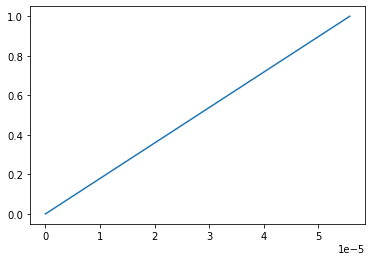

In [40]:
import matplotlib.pylab as plt
plt.plot(U_loaded, F_loaded)


# Uniaxial tension test

In [41]:
wb_mesh = FETriangularMesh(
    X_Id = [[0,0,0], [1000,0,0], [1000,1000,0],[0,1000,0]],
    I_Fi = [[0,1,2], [0,2,3]],
)
fixed_dofs = [0,1,2,4,5,7,8,9,11]
loaded_dofs = [3,6]

In [47]:
xdomain = WBXDomainFE(
    integ_factor = 1,
    mesh=wb_mesh
)

In [48]:
tmodel = MATS2DElastic(E_=1, nu=00)

In [49]:
u_cntl = 5000
bc_fixed = [BCDof(var= 'u', dof=dof, value=0 )
           for dof in fixed_dofs]
bc_loaded = [BCDof(var= 'f', dof=dof, value=u_cntl )
           for dof in loaded_dofs]

In [50]:
ts = TStepBC(
    domains=[(xdomain, tmodel)],
    bc=bc_fixed + bc_loaded,
)

In [51]:
s = ts.sim
s.tloop.k_max = 10
s.tline.step = 1
s.tloop.verbose = True
s.run()

t:	 0.00(0), 
	 1.00(1), 



In [52]:
U1 = ts.hist.U_t[-1]
print(U1)
eps1 = ts.fe_domain[0].xdomain.map_U_to_field(U1)
sig1, _ = ts.fe_domain[0].tmodel.get_corr_pred(eps1,1)
sig_x, sig_y, tau = sig1.T
sig_ab = np.einsum('ab...->...ab', np.array([[sig_x, tau], [tau, sig_y]], dtype=np.float))
sig_val, sig_dir = np.linalg.eig(sig_ab)
[np.min(sig_val), np.max(sig_val)]


[0.         0.         0.         0.29411765 0.         0.
 0.29411765 0.         0.         0.         0.         0.        ]


AttributeError: 'DomainState' object has no attribute 'xdomain'

In [53]:
sig1

NameError: name 'sig1' is not defined

In [73]:
sig_val

array([[ 1.00000000e+01, -3.39717867e-31],
       [ 1.00000000e+01,  8.88178420e-16]])